In [1]:
import sys
from pathlib import Path

root_dir = Path().resolve().parent
sys.path.append(str(root_dir))

from math import sqrt

import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

from lab1.src import (
    seed_everything,
    compute_pareto_mean,
    compute_pareto_variance,
    compute_theta
)
from lab3.src import (
    lscv_loss,
    lscv_loss_with_integral,
    smoothed_bootstrap_bandwidth,
    compute_knn_density,
    evaluate_densities,
)

seed_everything(42)

In [2]:
N = 5
S = 7
I1 = 7
I2 = 4

alpha_1 = 0.1
alpha_2 = 0.01

tau = 1 / (1 + I1)
p1 = (alpha_1 ** (1 - tau)) * (alpha_2 ** tau)
p2 = 5 * p1 / np.sqrt(S)

l = int((I2 + 2.5) / 2)

thetas = {
    1: (0, 1),
    2: (S, N),
    3: (N, S + 2),
    4: (S, S + N),
    5: (-N, S + 4),
}

pi_1 = S / (1 + I1 + 2 * N + S)
pi_2 = N / (1 + I1 + 2 * N + S)
pi_0 = 1 - pi_1 - pi_2

print(f"""
N = {N}
S = {S}
I1 = {I1}
I2 = {I2}
alpha_1 = {alpha_1}
alpha_2 = {alpha_2}
tau = {tau}
p1 = {p1}
p2 = {p2}
pi_1 = {pi_1}
pi_2 = {pi_2}
pi_0 = {pi_0}
l = {l}
thetas = {thetas}
""")


N = 5
S = 7
I1 = 7
I2 = 4
alpha_1 = 0.1
alpha_2 = 0.01
tau = 0.125
p1 = 0.07498942093324558
p2 = 0.14171668482150637
pi_1 = 0.28
pi_2 = 0.2
pi_0 = 0.52
l = 3
thetas = {1: (0, 1), 2: (7, 5), 3: (5, 9), 4: (7, 12), 5: (-5, 11)}



In [3]:
theta_0 = thetas[l]
mu0 = compute_pareto_mean(*theta_0)
v0 = compute_pareto_variance(*theta_0)

mu1 = mu0
v1 = N * v0

mu2 = mu0 + 2 * sqrt(v0)
v2 = v0 / S

theta_1 = compute_theta(mu1, v1)
theta_2 = compute_theta(mu2, v2)

print(f"""
theta_0 = {theta_0}
theta_1 = {theta_1}
theta_2 = {theta_2}
""")


theta_0 = (5, 9)
theta_1 = (4.425081346911984, 4.687817782917154)
theta_2 = (6.784503924546728, 27.310513300379103)



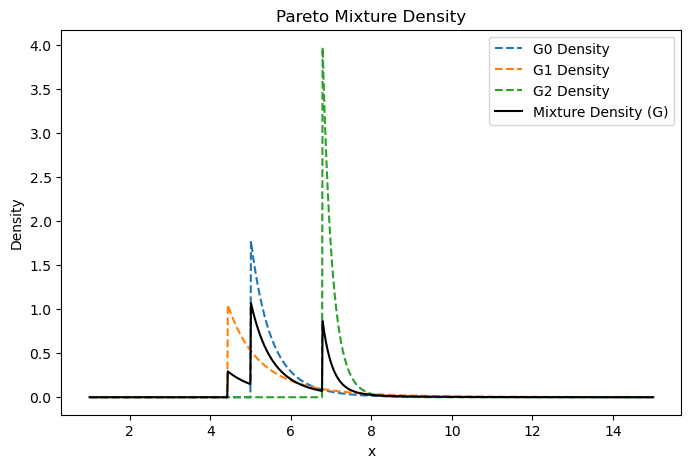

In [4]:
x_grid = np.linspace(1, 15, 1000)
G0_density = stats.pareto.pdf(x_grid, b=theta_0[1], scale=theta_0[0])
G1_density = stats.pareto.pdf(x_grid, b=theta_1[1], scale=theta_1[0])
G2_density = stats.pareto.pdf(x_grid, b=theta_2[1], scale=theta_2[0])
G_density = pi_0 * G0_density + pi_1 * G1_density + pi_2 * G2_density

plt.figure(figsize=(8, 5))
plt.plot(x_grid, G0_density, label="G0 Density", linestyle="--")
plt.plot(x_grid, G1_density, label="G1 Density", linestyle="--")
plt.plot(x_grid, G2_density, label="G2 Density", linestyle="--")
plt.plot(x_grid, G_density, label="Mixture Density (G)", color="black")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.title("Pareto Mixture Density")
plt.show()

Generated 700 samples from the Pareto mixture distribution.
Proportions: G0=0.52, G1=0.27, G2=0.21


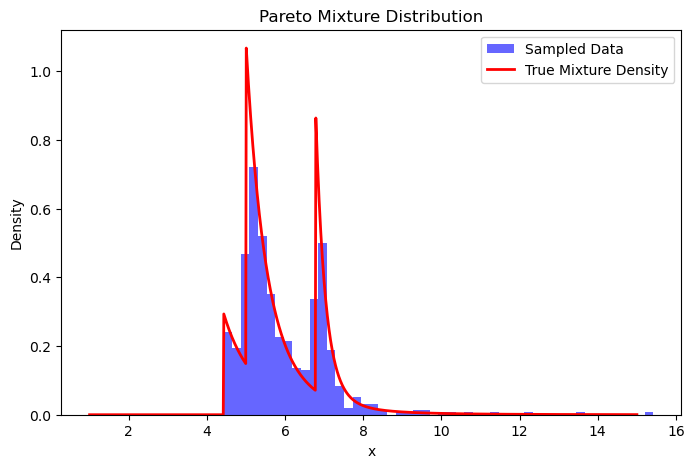

In [5]:
n_samples = 100 * (2 + N)
component_indices = np.random.choice([0, 1, 2], size=n_samples, p=[pi_0, pi_1, pi_2])

samples = np.zeros(n_samples)

samples[component_indices == 0] = stats.pareto.rvs(b=theta_0[1], scale=theta_0[0], size=(component_indices == 0).sum())
samples[component_indices == 1] = stats.pareto.rvs(b=theta_1[1], scale=theta_1[0], size=(component_indices == 1).sum())
samples[component_indices == 2] = stats.pareto.rvs(b=theta_2[1], scale=theta_2[0], size=(component_indices == 2).sum())

print(f"Generated {n_samples} samples from the Pareto mixture distribution.")

prop_0 = np.mean(component_indices == 0)
prop_1 = np.mean(component_indices == 1)
prop_2 = np.mean(component_indices == 2)

print(f"Proportions: G0={prop_0:.2f}, G1={prop_1:.2f}, G2={prop_2:.2f}")

plt.figure(figsize=(8, 5))
plt.hist(samples, bins=50, density=True, alpha=0.6, color='blue', label="Sampled Data")
plt.plot(x_grid, G_density, label="True Mixture Density", color="red", linewidth=2)
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.title("Pareto Mixture Distribution")
plt.show()

C:\Users\stosk\Desktop\Magistrantura\parametric non parametric statistics\pnp\lab3\src.py:50: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(squared_kde, min(x)-3*h, max(x)+3*h)


Optimal Bandwidth: 0.040815367346938775


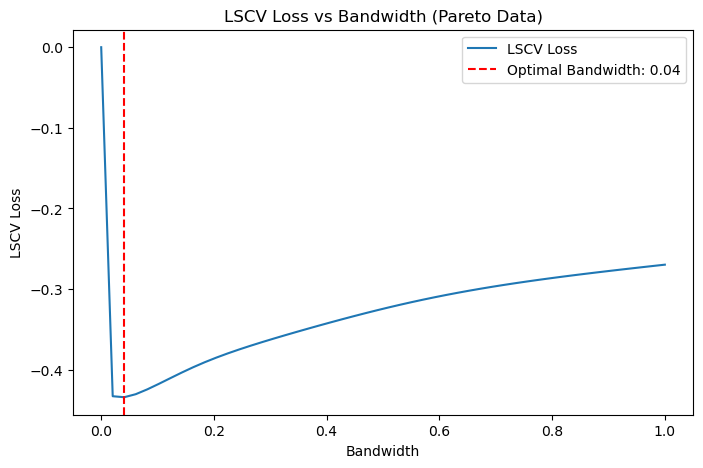

In [6]:
data = samples.copy()

bandwidths = np.linspace(-0.000001, 1, 50)
losses = [lscv_loss_with_integral( data, bw) for bw in bandwidths]
optimal_bw = bandwidths[np.argmin(losses)]

print(f"Optimal Bandwidth: {optimal_bw}")

plt.figure(figsize=(8, 5))
plt.plot(bandwidths, losses, label="LSCV Loss")
plt.axvline(optimal_bw, color="red", linestyle="--", label=f"Optimal Bandwidth: {optimal_bw:.2f}")
plt.xlabel("Bandwidth")
plt.ylabel("LSCV Loss")
plt.title("LSCV Loss vs Bandwidth (Pareto Data)")
plt.legend()
plt.show()

In [7]:
lscv_density = compute_kernel_density(x_grid, data, optimal_bw)
plt.figure(figsize=(8, 5))
plt.hist(data, bins=50, density=True, alpha=0.5, label="Histogram (Pareto Mixture)")
plt.plot(x_grid, lscv_density, label=f"KDE (Optimal BW={optimal_bw:.2f})", color="red")
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Kernel Density Estimation with LSCV (Pareto Mixture)")
plt.legend()
plt.show()

NameError: name 'compute_kernel_density' is not defined

Refined Plug-In Bandwidth: 0.3427638337929823


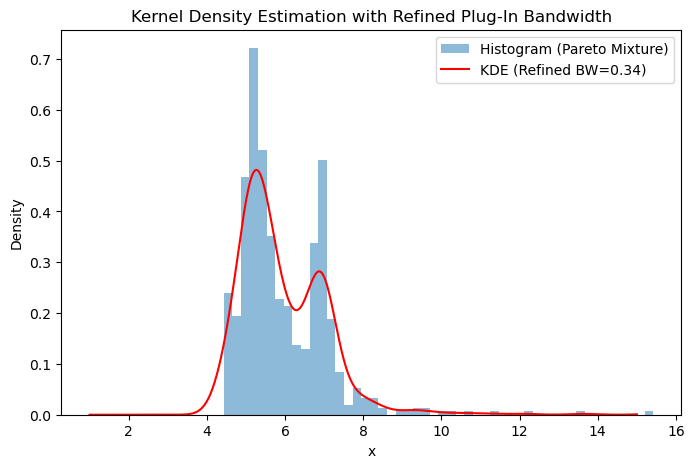

In [ ]:
data = samples.copy()
bandwidth = plugin_bandwidth(data)
print(f"Refined Plug-In Bandwidth: {bandwidth}")
kde = stats.gaussian_kde(data, bw_method=bandwidth / np.std(data))
plugin_density = kde(x_grid)

plt.figure(figsize=(8, 5))
plt.hist(data, bins=50, density=True, alpha=0.5, label="Histogram (Pareto Mixture)")
plt.plot(x_grid, plugin_density, label=f"KDE (Refined BW={bandwidth:.2f})", color="red")
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Kernel Density Estimation with Refined Plug-In Bandwidth")
plt.legend()
plt.show()

Smoothed Bootstrap Bandwidth: 1.3131744489511146


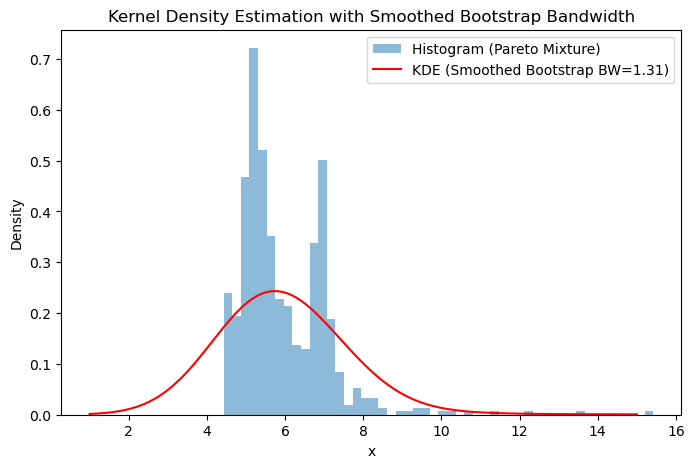

In [ ]:
data = samples.copy()

smoothed_bw = smoothed_bootstrap_bandwidth(data, n_bootstrap=1)
print(f"Smoothed Bootstrap Bandwidth: {smoothed_bw}")

kde = stats.gaussian_kde(data, bw_method=smoothed_bw / np.std(data))
smoothed_bs_density = kde(x_grid)

plt.figure(figsize=(8, 5))
plt.hist(data, bins=50, density=True, alpha=0.5, label="Histogram (Pareto Mixture)")
plt.plot(x_grid, smoothed_bs_density, label=f"KDE (Smoothed Bootstrap BW={smoothed_bw:.2f})", color="red")
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Kernel Density Estimation with Smoothed Bootstrap Bandwidth")
plt.legend()
plt.show()

In [ ]:
data = samples.copy()
k = 10
knn_density = compute_knn_density(data, x_grid, k)

plt.figure(figsize=(8, 5))
plt.hist(data, bins=50, density=True, alpha=0.5, label="Histogram (Pareto Mixture)")
plt.plot(x_grid, knn_density, label=f"k-NN Density (k={k})", color="red")
plt.xlabel("x")
plt.ylabel("Density")
plt.title("k-Nearest Neighbors Density Estimation")
plt.legend()
plt.show()

TypeError: Subscripted generics cannot be used with class and instance checks

In [60]:
evaluate_densities(
    true_density=G_density,
    predicted_densities=[lscv_density, plugin_density, smoothed_bs_density, knn_density],
    x_grid=x_grid,
    n_samples=2000,
    method_names=["LSCV KDE", "Plug-In KDE", "Smoothed KDE", "k-NN Density"],
    seed=1
)

Method                   KS-Stat   KS-Pval   ISE       MAE       KL Div    
--------------------------------------------------------------------------------
LSCV KDE                 0.042000  0.058717  0.019267  0.395054  0.115493  
Plug-In KDE              0.074500  0.000030  0.088072  0.667356  0.162013  
Smoothed KDE             0.050500  0.012177  0.041144  0.553878  0.089951  
k-NN Density             0.037000  0.129372  0.038011  0.481980  0.077432  
